<a href="https://colab.research.google.com/github/tajbirahmed/Image-captioning-transformer/blob/main/image_captioning_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')
    captions = (path/'Flickr8k_text.zip/Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr8k_text.zip/Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr8k_text.zip/Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flickr8k_Dataset.zip/Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [6]:
get_data()
train_raw, test_raw = get_dataset()

In [7]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [8]:
image_shape = (224, 224, 3)
feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_preprocessing = True, include_top = False)
feature_extractor.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [10]:
img = load_img(img_path.numpy().decode('utf-8'))
print(img.shape)
print(feature_extractor(img[tf.newaxis, ...]).shape)

(224, 224, 3)
(1, 7, 7, 576)


In [11]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [12]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [13]:
vocab_size = 5000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [14]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


In [15]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

In [16]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [17]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


In [18]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [19]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 64):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

In [20]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

  0%|          | 0/94 [00:01<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 57.2 s, sys: 10.3 s, total: 1min 7s
Wall time: 1min 6s


In [21]:
def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [22]:
batch_size = 64
train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

In [23]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(64, 7, 7, 576)
(64, 32)
(64, 32)
tf.Tensor(
[  3   2 529   8  35   7   6  69  11  95  10   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(32,), dtype=int64)
tf.Tensor(
[  2 529   8  35   7   6  69  11  95  10   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(32,), dtype=int64)


In [24]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [25]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [26]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

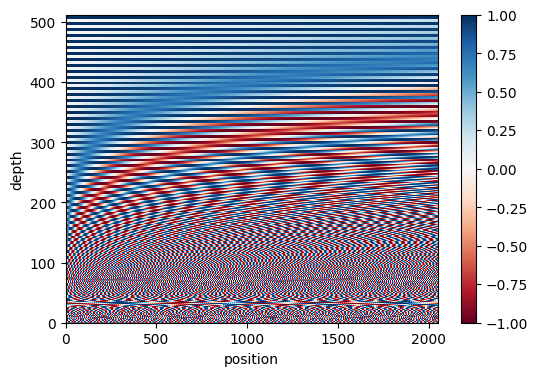

In [27]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

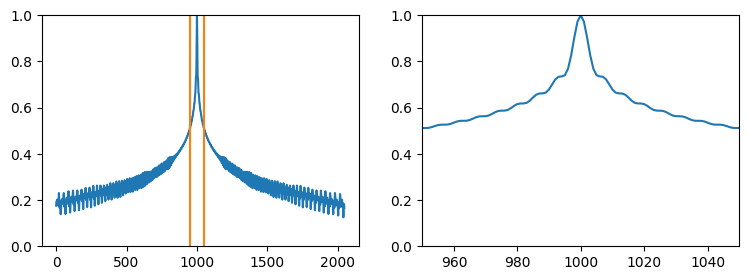

In [28]:
p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis = 1)
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b = True)

plt.figure(figsize = (9, 3))
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])

plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.xlim([950, 1050])
plt.show()

In [29]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [30]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(64, 32, 512)


In [31]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [32]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [33]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(64, 32, 512)


In [34]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [35]:
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(64, 7, 7, 576) (64, 49, 576)
(64, 32, 512)


In [36]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [37]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(64, 32, 512)


In [38]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [39]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(64, 32, 512)


In [40]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [41]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.517193191416236
curr_entropy : 5.292547935444456
(64, 32, 5000)


In [42]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [43]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)
(64, 49, 576)


In [44]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_2' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 512)
(64, 8, 37, 49)
CPU times: user 4.04 s, sys: 436 ms, total: 4.48 s
Wall time: 5.63 s


In [45]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [46]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_8' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)
(64, 37)


Model: "captioner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (OutputLayer)           │ ?                           │       2,565,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │     119,139,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,643,448 (467.85 MB)

 Trainable params: 121,704,328 (464.27 MB)

 Non-trainable params: 939,120 (3.58 MB)

None
CPU times: user 4.7 s, sys: 965 ms, total: 5.67 s
Wall time: 5.83 s


In [47]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416236
curr_entropy : 5.292547935444456


In [48]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(64, 7, 7, 576)
(64, 37)
(64, 37)


In [49]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
captioner_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 37, 5000)


Model: "captioner_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_1 (OutputLayer)         │ ?                           │         645,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Decoder)                  │ ?                           │       1,694,208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,278,328 (12.51 MB)

 Trainable params: 2,339,208 (8.92 MB)

 Non-trainable params: 939,120 (3.58 MB)

CPU times: user 1.67 s, sys: 299 ms, total: 1.97 s
Wall time: 1.97 s


In [50]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

In [51]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [52]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [53]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [54]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(64, 7, 7, 576)
(64, 34)
(64, 34)
(64, 34, 5000)
tf.Tensor(5.3808684, shape=(), dtype=float32)
tf.Tensor(0.13863929, shape=(), dtype=float32)


tf.Tensor(b'flickr8k/Flickr8k_Dataset.zip/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
(224, 224, 3)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


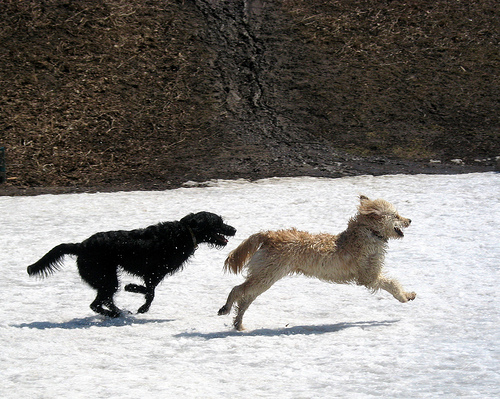

In [55]:
for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [56]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [57]:
sample_gen_text = GenerateText()
sample_gen_text.model = captioner_model
sample_gen_text.on_epoch_end(0)

AttributeError: property 'model' of 'GenerateText' object has no setter

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
callbacks = [GenerateText(),
             tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]

In [60]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [62]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [63]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 150,
    callbacks = callbacks
)

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.6847 - masked_accuracy: 0.2467



/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_attention_14' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Generated_text: a black dog is is in a swing, 	 f_score: 0
Generated_text: a dog is to a white dog to a a white dog is in a dog, 	 f_score: 0
Generated_text: a dog, 	 f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 4.6840 - masked_accuracy: 0.2468 - val_loss: 4.3959 - val_masked_accuracy: 0.2687
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.4061 - masked_accuracy: 0.2731

Generated_text: a dog is running in the a black dog, 	 f_score: 0.4663130097672397
Generated_text: a dog is in a black dog is is standing in the a getting the on a brown dog, 	 f_score: 0.43749999999999994
Generated_text: a dog is a white dog, 	 f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 4.4055 - masked_accuracy: 0.2732 - val_loss: 4.2031 - val_masked_accuracy: 0.2898
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.2381 - masked_accuracy: 0.2970

Generated_text: a dogs in a white dog is running in the water, 	 f_score: 0.48635586887718857
Generated_text:

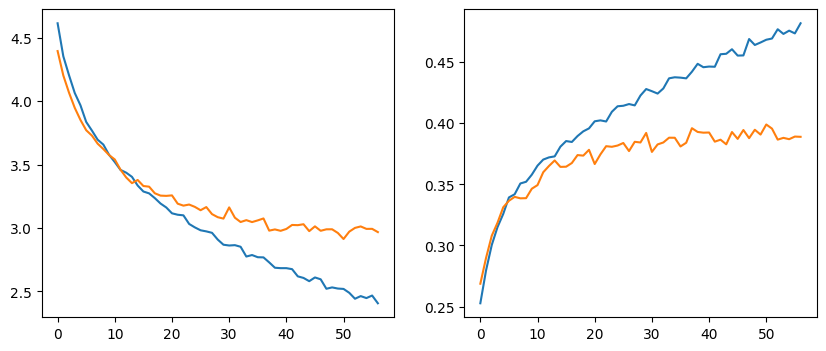

In [64]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')
plt.plot(hist.history['val_masked_accuracy'], label = 'val_masked_accuracy')
plt.show()

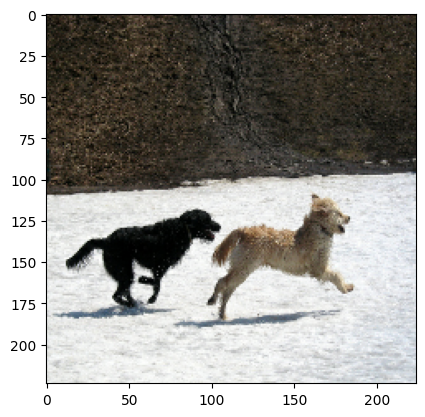

Generated Caption: two dogs stand in the snow


In [ ]:
for img_path, caps in train_raw.batch(4).take(1):
    break

img = load_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

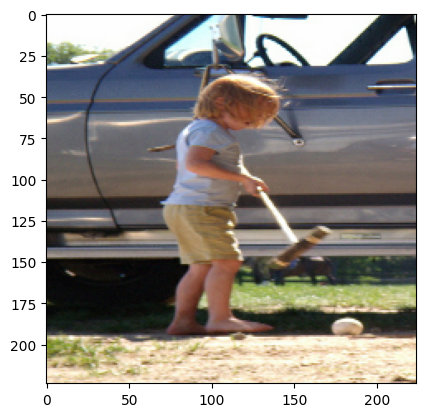

Generated Caption: a girl walking on a white dog with a dog in the background


In [ ]:
img = load_img(img_path[1].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

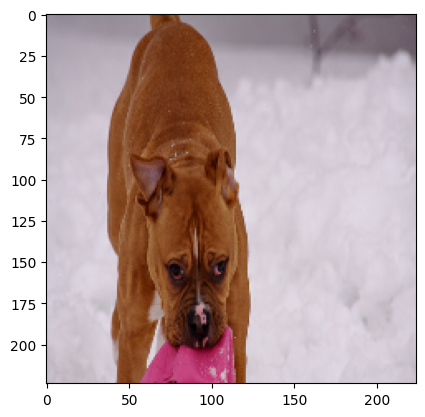

Generated Caption: a dog wearing a pink coat and pink shirt stands in the snow


In [ ]:
img = load_img(img_path[2].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

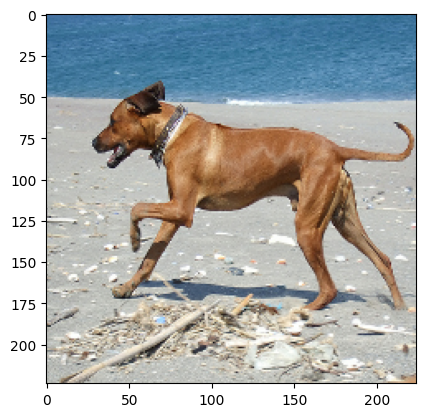

Generated Caption: a brown dog stands on a beach


In [ ]:
img = load_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

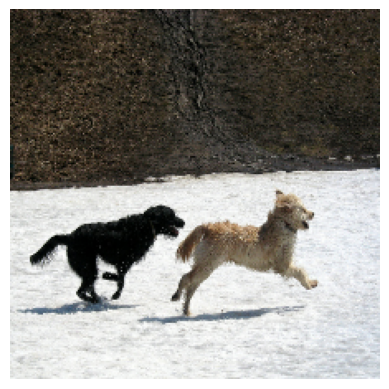

two dogs running in the snow


In [ ]:
for img_path, cap in train_raw.take(1):
    break
img = load_img(img_path)
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])

plt.imshow(img/255)
plt.axis('off')
plt.show()
print(cap_gen)

In [ ]:
cap_gen_tokens = cap_gen.split() + ['[END]']
print(len(cap_gen_tokens))

7


In [ ]:
attn_scores = captioner_model.decoder.last_attention_scores
print(attn_scores.shape)
attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')
print(attn_maps.shape)

(1, 2, 7, 49)
(7, 7, 7)


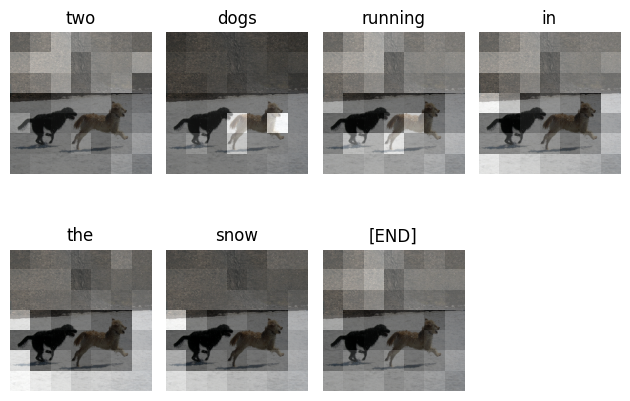

In [ ]:
len_result = len(attn_maps)
col_len = int(np.ceil(len_result/2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i+1)
    img_plot = ax.imshow(img/255)
    plt.title(cap_gen_tokens[i])
    ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = cap_gen.split() + ['[END]']
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')

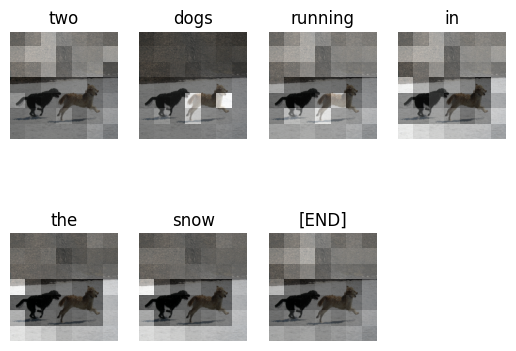

In [ ]:
captioner_model.show_attention(img)